In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [41]:
def get_stock_data(sym, start_date, end_date,interval_):
    # interval_ = '15m' # [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
    data = yf.download(sym, start=start_date, end=end_date, interval=interval_)
    return data


In [42]:
def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler


In [43]:
def split_data(data, train_size):
    train_size = int(len(data) * train_size)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

In [44]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([item[0] for item in sequences]), np.array([item[1] for item in sequences])


In [45]:
def build_lstm_model(seq_length):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, epochs):
    model.fit(X_train, y_train, epochs=epochs, batch_size=64)


In [46]:
def make_predictions(model, X_test):
    return model.predict(X_test)


In [47]:
def inverse_predictions(predictions, scaler):
    return scaler.inverse_transform(predictions)

In [48]:
def plot_results(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Price', color='blue')
    plt.plot(predicted, label='Predicted Price', color='red')
    plt.title('Comparaison des prix réels et prédits')
    plt.xlabel('Index')
    plt.ylabel('Prix')
    plt.legend()
    plt.show()

## load train data 

In [49]:
# Étape 1 : Télécharger les données
data = get_stock_data('EURUSD=X', '2023-07-22', '2023-09-16','5m')
print(data.shape)
data

[*********************100%%**********************]  1 of 1 completed
(11366, 6)


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-07-24 00:00:00+01:00,1.113214,1.113338,1.113214,1.113214,1.113214,0
2023-07-24 00:05:00+01:00,1.113214,1.113214,1.113214,1.113214,1.113214,0
2023-07-24 00:10:00+01:00,1.113214,1.113214,1.113214,1.113214,1.113214,0
2023-07-24 00:15:00+01:00,1.113214,1.113214,1.113090,1.113214,1.113214,0
2023-07-24 00:20:00+01:00,1.113214,1.113214,1.113214,1.113214,1.113214,0
...,...,...,...,...,...,...
2023-09-15 22:05:00+01:00,1.066212,1.066212,1.066212,1.066212,1.066212,0
2023-09-15 22:10:00+01:00,1.066212,1.066212,1.066212,1.066212,1.066212,0
2023-09-15 22:15:00+01:00,1.066212,1.066212,1.066212,1.066212,1.066212,0


In [50]:
# Étape 2 : Prétraiter les données
scaled_data, scaler = preprocess_data(data)

# Étape 3 : Diviser les données
train_data, test_data = split_data(scaled_data, train_size=0.9)

# Étape 4 : Créer des séquences temporelles
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Étape 5 : Construire le modèle LSTM
model = build_lstm_model(seq_length)

# Étape 6 : Entraîner le modèle
train_model(model, X_train, y_train, epochs=1000)


Epoch 1/1000
160/160 [==============================] - 16s 54ms/step - loss: 0.0248
Epoch 2/1000
160/160 [==============================] - 8s 48ms/step - loss: 0.0012
Epoch 3/1000
160/160 [==============================] - 8s 49ms/step - loss: 9.2423e-04
Epoch 4/1000
160/160 [==============================] - 8s 49ms/step - loss: 7.8245e-04
Epoch 5/1000
160/160 [==============================] - 8s 50ms/step - loss: 6.4181e-04
Epoch 6/1000
160/160 [==============================] - 8s 51ms/step - loss: 5.8248e-04
Epoch 7/1000
160/160 [==============================] - 10s 60ms/step - loss: 5.1743e-04
Epoch 8/1000
160/160 [==============================] - 9s 57ms/step - loss: 4.9641e-04
Epoch 9/1000
160/160 [==============================] - 8s 51ms/step - loss: 4.2745e-04
Epoch 10/1000
160/160 [==============================] - 9s 55ms/step - loss: 4.3046e-04
Epoch 11/1000
160/160 [==============================] - 8s 52ms/step - loss: 4.1311e-04
Epoch 12/1000
160/160 [=============

160/160 [==============================] - 8s 49ms/step - loss: 1.2773e-04
Epoch 94/1000
160/160 [==============================] - 8s 47ms/step - loss: 1.2479e-04
Epoch 95/1000
160/160 [==============================] - 7s 46ms/step - loss: 1.2314e-04
Epoch 96/1000
160/160 [==============================] - 7s 46ms/step - loss: 1.4914e-04
Epoch 97/1000
160/160 [==============================] - 8s 48ms/step - loss: 1.2915e-04
Epoch 98/1000
160/160 [==============================] - 7s 46ms/step - loss: 1.2073e-04
Epoch 99/1000
160/160 [==============================] - 7s 46ms/step - loss: 1.1850e-04
Epoch 100/1000
160/160 [==============================] - 8s 47ms/step - loss: 1.1858e-04
Epoch 101/1000
160/160 [==============================] - 7s 46ms/step - loss: 1.3017e-04
Epoch 102/1000
160/160 [==============================] - 8s 50ms/step - loss: 1.1598e-04
Epoch 103/1000
160/160 [==============================] - 7s 46ms/step - loss: 1.2323e-04
Epoch 104/1000
160/160 [=======

160/160 [==============================] - 8s 51ms/step - loss: 7.4612e-05
Epoch 185/1000
160/160 [==============================] - 8s 52ms/step - loss: 7.6580e-05
Epoch 186/1000
160/160 [==============================] - 8s 51ms/step - loss: 7.4041e-05
Epoch 187/1000
160/160 [==============================] - 10s 61ms/step - loss: 6.8686e-05
Epoch 188/1000
160/160 [==============================] - 10s 64ms/step - loss: 7.4509e-05
Epoch 189/1000
160/160 [==============================] - 10s 65ms/step - loss: 7.2426e-05
Epoch 190/1000
160/160 [==============================] - 10s 65ms/step - loss: 7.3851e-05
Epoch 191/1000
160/160 [==============================] - 8s 52ms/step - loss: 7.4971e-05
Epoch 192/1000
160/160 [==============================] - 10s 63ms/step - loss: 8.5566e-05
Epoch 193/1000
160/160 [==============================] - 11s 66ms/step - loss: 7.1239e-05
Epoch 194/1000
160/160 [==============================] - 12s 77ms/step - loss: 7.5633e-05
Epoch 195/1000
160

160/160 [==============================] - 8s 48ms/step - loss: 6.1407e-05
Epoch 275/1000
160/160 [==============================] - 8s 52ms/step - loss: 5.8374e-05
Epoch 276/1000
160/160 [==============================] - 9s 53ms/step - loss: 5.9975e-05
Epoch 277/1000
160/160 [==============================] - 8s 51ms/step - loss: 6.2262e-05
Epoch 278/1000
160/160 [==============================] - 8s 53ms/step - loss: 6.1805e-05
Epoch 279/1000
160/160 [==============================] - 9s 54ms/step - loss: 6.0391e-05
Epoch 280/1000
160/160 [==============================] - 8s 52ms/step - loss: 6.1608e-05
Epoch 281/1000
160/160 [==============================] - 9s 54ms/step - loss: 6.2600e-05
Epoch 282/1000
160/160 [==============================] - 8s 52ms/step - loss: 5.7899e-05
Epoch 283/1000
160/160 [==============================] - 8s 52ms/step - loss: 5.7452e-05
Epoch 284/1000
160/160 [==============================] - 8s 52ms/step - loss: 5.9597e-05
Epoch 285/1000
160/160 [=

160/160 [==============================] - 8s 53ms/step - loss: 5.4065e-05
Epoch 366/1000
160/160 [==============================] - 8s 50ms/step - loss: 5.3102e-05
Epoch 367/1000
160/160 [==============================] - 8s 48ms/step - loss: 5.1443e-05
Epoch 368/1000
160/160 [==============================] - 8s 48ms/step - loss: 5.2132e-05
Epoch 369/1000
160/160 [==============================] - 8s 50ms/step - loss: 5.3840e-05
Epoch 370/1000
160/160 [==============================] - 9s 55ms/step - loss: 5.4743e-05
Epoch 371/1000
160/160 [==============================] - 8s 50ms/step - loss: 5.1007e-05
Epoch 372/1000
160/160 [==============================] - 8s 50ms/step - loss: 5.2258e-05
Epoch 373/1000
160/160 [==============================] - 9s 54ms/step - loss: 5.0574e-05
Epoch 374/1000
160/160 [==============================] - 8s 51ms/step - loss: 4.9172e-05
Epoch 375/1000
160/160 [==============================] - 9s 55ms/step - loss: 5.4278e-05
Epoch 376/1000
160/160 [=

160/160 [==============================] - 9s 56ms/step - loss: 4.7159e-05
Epoch 456/1000
160/160 [==============================] - 9s 59ms/step - loss: 4.7879e-05
Epoch 457/1000
160/160 [==============================] - 12s 75ms/step - loss: 4.9920e-05
Epoch 458/1000
160/160 [==============================] - 13s 79ms/step - loss: 4.9291e-05
Epoch 459/1000
160/160 [==============================] - 13s 79ms/step - loss: 5.1495e-05
Epoch 460/1000
160/160 [==============================] - 13s 82ms/step - loss: 4.5969e-05
Epoch 461/1000
160/160 [==============================] - 12s 78ms/step - loss: 4.7675e-05
Epoch 462/1000
160/160 [==============================] - 12s 76ms/step - loss: 4.9032e-05
Epoch 463/1000
160/160 [==============================] - 8s 49ms/step - loss: 5.2259e-05
Epoch 464/1000
160/160 [==============================] - 8s 48ms/step - loss: 4.9234e-05
Epoch 465/1000
160/160 [==============================] - 8s 48ms/step - loss: 4.6933e-05
Epoch 466/1000
160/

160/160 [==============================] - 8s 48ms/step - loss: 4.5767e-05
Epoch 546/1000
160/160 [==============================] - 8s 47ms/step - loss: 4.3931e-05
Epoch 547/1000
160/160 [==============================] - 8s 48ms/step - loss: 4.7162e-05
Epoch 548/1000
160/160 [==============================] - 8s 47ms/step - loss: 4.5058e-05
Epoch 549/1000
160/160 [==============================] - 8s 48ms/step - loss: 4.6164e-05
Epoch 550/1000
160/160 [==============================] - 8s 51ms/step - loss: 4.7357e-05
Epoch 551/1000
160/160 [==============================] - 8s 47ms/step - loss: 4.7014e-05
Epoch 552/1000
160/160 [==============================] - 8s 47ms/step - loss: 4.7223e-05
Epoch 553/1000
160/160 [==============================] - 8s 47ms/step - loss: 4.4015e-05
Epoch 554/1000
160/160 [==============================] - 8s 48ms/step - loss: 4.7846e-05
Epoch 555/1000
160/160 [==============================] - 8s 47ms/step - loss: 4.6981e-05
Epoch 556/1000
160/160 [=

160/160 [==============================] - 12s 75ms/step - loss: 4.4907e-05
Epoch 636/1000
160/160 [==============================] - 13s 78ms/step - loss: 4.4826e-05
Epoch 637/1000
160/160 [==============================] - 12s 76ms/step - loss: 4.9187e-05
Epoch 638/1000
160/160 [==============================] - 13s 80ms/step - loss: 4.3864e-05
Epoch 639/1000
160/160 [==============================] - 14s 86ms/step - loss: 4.4741e-05
Epoch 640/1000
160/160 [==============================] - 14s 84ms/step - loss: 4.4586e-05
Epoch 641/1000
160/160 [==============================] - 13s 84ms/step - loss: 4.3812e-05
Epoch 642/1000
160/160 [==============================] - 11s 67ms/step - loss: 4.3068e-05
Epoch 643/1000
160/160 [==============================] - 13s 80ms/step - loss: 4.4831e-05
Epoch 644/1000
160/160 [==============================] - 12s 75ms/step - loss: 4.5332e-05
Epoch 645/1000
160/160 [==============================] - 11s 69ms/step - loss: 4.3743e-05
Epoch 646/1000

160/160 [==============================] - 20s 124ms/step - loss: 4.1165e-05
Epoch 726/1000
160/160 [==============================] - 11s 68ms/step - loss: 4.3310e-05
Epoch 727/1000
160/160 [==============================] - 14s 85ms/step - loss: 4.3204e-05
Epoch 728/1000
160/160 [==============================] - 13s 79ms/step - loss: 4.1546e-05
Epoch 729/1000
160/160 [==============================] - 10s 61ms/step - loss: 4.4114e-05
Epoch 730/1000
160/160 [==============================] - 15s 92ms/step - loss: 4.4423e-05
Epoch 731/1000
160/160 [==============================] - 13s 82ms/step - loss: 4.4895e-05
Epoch 732/1000
160/160 [==============================] - 18s 112ms/step - loss: 4.1578e-05
Epoch 733/1000
160/160 [==============================] - 18s 113ms/step - loss: 4.2586e-05
Epoch 734/1000
160/160 [==============================] - 18s 112ms/step - loss: 4.3713e-05
Epoch 735/1000
160/160 [==============================] - 18s 111ms/step - loss: 4.1993e-05
Epoch 736

160/160 [==============================] - 10s 61ms/step - loss: 4.2507e-05
Epoch 816/1000
160/160 [==============================] - 8s 50ms/step - loss: 4.2906e-05
Epoch 817/1000
160/160 [==============================] - 10s 61ms/step - loss: 4.2995e-05
Epoch 818/1000
160/160 [==============================] - 11s 71ms/step - loss: 4.0829e-05
Epoch 819/1000
160/160 [==============================] - 12s 77ms/step - loss: 4.1844e-05
Epoch 820/1000
160/160 [==============================] - 12s 74ms/step - loss: 4.2230e-05
Epoch 821/1000
160/160 [==============================] - 12s 73ms/step - loss: 4.2646e-05
Epoch 822/1000
160/160 [==============================] - 12s 74ms/step - loss: 4.1319e-05
Epoch 823/1000
160/160 [==============================] - 12s 77ms/step - loss: 3.9775e-05
Epoch 824/1000
160/160 [==============================] - 12s 72ms/step - loss: 4.2289e-05
Epoch 825/1000
160/160 [==============================] - 12s 72ms/step - loss: 4.1378e-05
Epoch 826/1000


160/160 [==============================] - 13s 79ms/step - loss: 3.9956e-05
Epoch 906/1000
160/160 [==============================] - 13s 84ms/step - loss: 4.1927e-05
Epoch 907/1000
160/160 [==============================] - 14s 87ms/step - loss: 4.1802e-05
Epoch 908/1000
160/160 [==============================] - 13s 81ms/step - loss: 3.8951e-05
Epoch 909/1000
160/160 [==============================] - 13s 79ms/step - loss: 4.0052e-05
Epoch 910/1000
160/160 [==============================] - 13s 82ms/step - loss: 4.0493e-05
Epoch 911/1000
160/160 [==============================] - 14s 86ms/step - loss: 3.8725e-05
Epoch 912/1000
160/160 [==============================] - 14s 90ms/step - loss: 4.0156e-05
Epoch 913/1000
160/160 [==============================] - 12s 75ms/step - loss: 4.1985e-05
Epoch 914/1000
160/160 [==============================] - 13s 79ms/step - loss: 4.1972e-05
Epoch 915/1000
160/160 [==============================] - 13s 84ms/step - loss: 4.1536e-05
Epoch 916/1000

160/160 [==============================] - 10s 65ms/step - loss: 3.9661e-05
Epoch 996/1000
160/160 [==============================] - 11s 68ms/step - loss: 3.9324e-05
Epoch 997/1000
160/160 [==============================] - 11s 68ms/step - loss: 4.0402e-05
Epoch 998/1000
160/160 [==============================] - 11s 66ms/step - loss: 4.0406e-05
Epoch 999/1000
160/160 [==============================] - 11s 67ms/step - loss: 3.9922e-05
Epoch 1000/1000
160/160 [==============================] - 10s 65ms/step - loss: 3.9384e-05


36/36 [==============================] - 1s 26ms/step


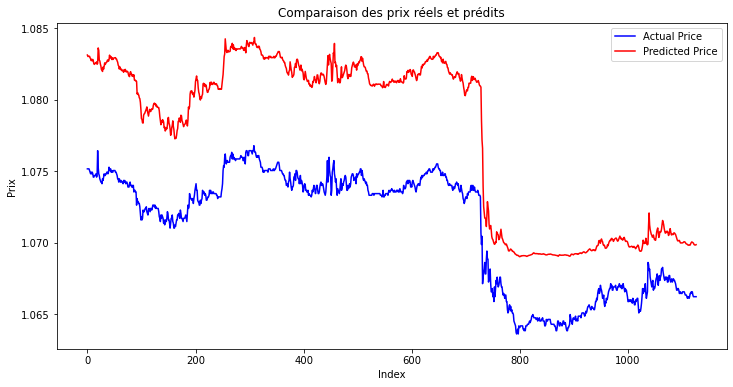

In [78]:
# Étape 7 : Faire des prédictions
predictions = make_predictions(model, X_test)

# Étape 8 : Inverser les prédictions
actual_predictions = inverse_predictions(predictions, scaler)

# Les prédictions sont maintenant dans la même échelle que les prix réels
actual_y_test = inverse_predictions(y_test[:,:,0], scaler)

plot_results(actual_y_test, actual_predictions)

In [75]:
data_test = get_stock_data('EURUSD=X', '2023-09-17', '2023-09-21','15m')

scaled_data_test, scaler_data_test = preprocess_data(data_test)

seq_length = 10
X_data_test, y_data_test = create_sequences(scaled_data_test, seq_length)

predictions_data_test = make_predictions(model, X_data_test)

actual_predictions = inverse_predictions(predictions_data_test, scaler_data_test)

actual_y_data_test = inverse_predictions(y_data_test[:,:,0], scaler_data_test)

[*********************100%%**********************]  1 of 1 completed
8/8 [==============================] - 0s 20ms/step


In [76]:
data_test

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-18 00:00:00,1.066667,1.066780,1.066553,1.066780,1.066780,0
2023-09-18 00:15:00,1.066780,1.066780,1.066667,1.066780,1.066780,0
2023-09-18 00:30:00,1.066780,1.067008,1.066667,1.067008,1.067008,0
2023-09-18 00:45:00,1.067008,1.067122,1.066894,1.067122,1.067122,0
2023-09-18 01:00:00,1.067008,1.067464,1.067008,1.067350,1.067350,0
...,...,...,...,...,...,...
2023-09-20 10:45:00,1.069976,1.070205,1.069747,1.070205,1.070205,0
2023-09-20 11:00:00,1.070205,1.070549,1.070205,1.070435,1.070435,0
2023-09-20 11:15:00,1.070435,1.070549,1.070205,1.070205,1.070205,0


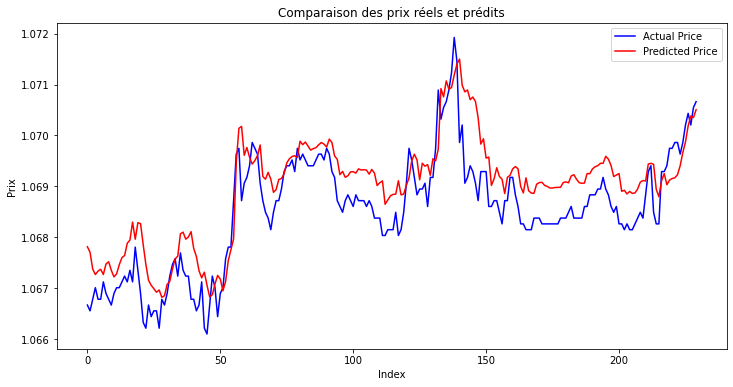

In [77]:
plot_results(actual_y_data_test, actual_predictions)

## Saving model

In [61]:
model_json = model.to_json()
with open("model_LSTM.json","w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model_LSTM_weights.h5")

## Loading model

In [63]:
from keras.models import model_from_json

json_file = open("model_LSTM.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_LSTM_weights.h5")

## test loaded_model

[*********************100%%**********************]  1 of 1 completed
8/8 [==============================] - 0s 24ms/step


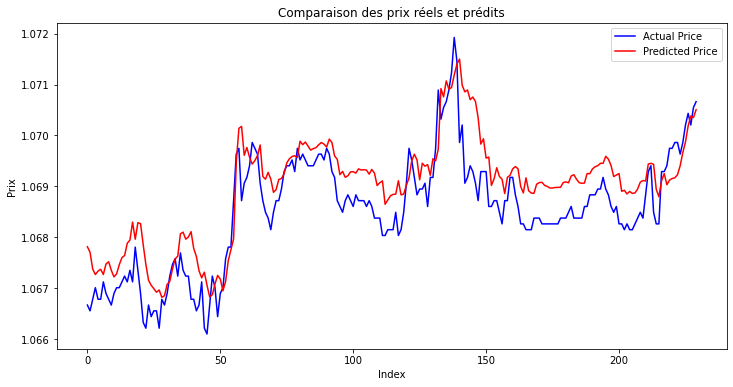

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-18 00:00:00,1.066667,1.066780,1.066553,1.066780,1.066780,0
2023-09-18 00:15:00,1.066780,1.066780,1.066667,1.066780,1.066780,0
2023-09-18 00:30:00,1.066780,1.067008,1.066667,1.067008,1.067008,0
2023-09-18 00:45:00,1.067008,1.067122,1.066894,1.067122,1.067122,0
2023-09-18 01:00:00,1.067008,1.067464,1.067008,1.067350,1.067350,0
...,...,...,...,...,...,...
2023-09-20 10:45:00,1.069976,1.070205,1.069747,1.070205,1.070205,0
2023-09-20 11:00:00,1.070205,1.070549,1.070205,1.070435,1.070435,0
2023-09-20 11:15:00,1.070435,1.070549,1.070205,1.070205,1.070205,0


In [79]:
data_test = get_stock_data('EURUSD=X', '2023-09-17', '2023-09-21','15m')
scaled_data_test, scaler_data_test = preprocess_data(data_test)

seq_length = 10
X_data_test, y_data_test = create_sequences(scaled_data_test, seq_length)

predictions_data_test = make_predictions(loaded_model, X_data_test)

actual_predictions = inverse_predictions(predictions_data_test, scaler_data_test)

actual_y_data_test = inverse_predictions(y_data_test[:,:,0], scaler_data_test)
plot_results(actual_y_data_test, actual_predictions)
data_test